<h1> 영화리뷰 텍스트 감성분석하기 <h1>

단어의 의미를 나타내는 벡터를 짝지어 보자

단 3개의 짧은 문장으로 이루어진 텍스트 데이터를 처리하는 간단한 예제를 시도해보기...

i feel hungry

i eat lunch

now i feel happy

In [1]:
# 처리해야 할 문장을 파이썬 리스트에 옮겨 담았습니다.
sentences=['i feel hungry', 'i eat lunch', 'now i feel happy']

# 파이썬 split() 메소드를 이용해 단어 단위로 문장을 쪼개 봅니다.
word_list = 'i feel hungry'.split()
print(word_list)

['i', 'feel', 'hungry']


텍스트 데이터로부터 사전을 만들기 위해 모든 문장을 단어 단위로 쪼갠 후에 파이썬 딕셔너리(dict) 자료구조로 표현

In [2]:
index_to_word={}  # 빈 딕셔너리를 만들어서

# 단어들을 하나씩 채워 봅니다. 채우는 순서는 일단 임의로 하였습니다. 그러나 사실 순서는 중요하지 않습니다. 
# <BOS>, <PAD>, <UNK>는 관례적으로 딕셔너리 맨 앞에 넣어줍니다. 
index_to_word[0]='<PAD>'  # 패딩용 단어
index_to_word[1]='<BOS>'  # 문장의 시작지점
index_to_word[2]='<UNK>'  # 사전에 없는(Unknown) 단어
index_to_word[3]='i'
index_to_word[4]='feel'
index_to_word[5]='hungry'
index_to_word[6]='eat'
index_to_word[7]='lunch'
index_to_word[8]='now'
index_to_word[9]='happy'

print(index_to_word)

{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: 'i', 4: 'feel', 5: 'hungry', 6: 'eat', 7: 'lunch', 8: 'now', 9: 'happy'}


텍스트 데이터를 숫자로 바꾸려면 위의 딕셔너리가 {텍스트:인덱스} 구조여야 한다.

In [3]:
word_to_index={word:index for index, word in index_to_word.items()}
print(word_to_index)

{'<PAD>': 0, '<BOS>': 1, '<UNK>': 2, 'i': 3, 'feel': 4, 'hungry': 5, 'eat': 6, 'lunch': 7, 'now': 8, 'happy': 9}


In [4]:
print(word_to_index['feel'])  # 단어 'feel'은 숫자 인덱스 4로 바뀝니다.

4


텍스트 데이터를 숫자로 바꿔 표현해 보기

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트로 변환해 주는 함수를 만들어 봅시다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

print(get_encoded_sentence('i eat lunch', word_to_index))

[1, 3, 6, 7]


In [6]:
# 여러 개의 문장 리스트를 한꺼번에 숫자 텐서로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# sentences=['i feel hungry', 'i eat lunch', 'now i feel happy'] 가 아래와 같이 변환됩니다. 
encoded_sentences = get_encoded_sentences(sentences, word_to_index)
print(encoded_sentences)

[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]]


In [7]:
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

print(get_decoded_sentence([1, 3, 4, 5], index_to_word))

i feel hungry


In [8]:
# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# encoded_sentences=[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 가 아래와 같이 변환됩니다.
print(get_decoded_sentences(encoded_sentences, index_to_word))

['i feel hungry', 'i eat lunch', 'now i feel happy']


Embedding 레이어의 인풋이 되는 문장 벡터는 그 길이가 일정해야 하기때문에 

keras.preprocessing.sequence.pad_sequences 함수를 통해 문장 벡터 뒤에 패딩(< PAD >)을 추가하여 길이를 일정하게 맞추기

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4    # 위 그림과 같이 4차원의 워드 벡터를 가정합니다. 

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# 숫자로 변환된 텍스트 데이터 [[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 에 Embedding 레이어를 적용합니다. 
# list 형태의 sentences는 numpy array로 변환되어야 딥러닝 레이어의 입력이 될 수 있습니다.

raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index))
output = embedding(raw_inputs)
print(output)



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).

In [10]:
raw_inputs = keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=5)
print(raw_inputs)

[[1 3 4 5 0]
 [1 3 6 7 0]
 [1 8 3 4 9]]


In [11]:
import numpy as np
import tensorflow as tf

vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4    # 그림과 같이 4차원의 워드 벡터를 가정합니다.

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# keras.preprocessing.sequence.pad_sequences를 통해 word vector를 모두 일정 길이로 맞춰주어야 
# embedding 레이어의 input이 될 수 있음에 주의해 주세요. 
raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index))
raw_inputs = keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=5)
output = embedding(raw_inputs)
print(output)

tf.Tensor(
[[[-0.03703382 -0.03062358 -0.03676515 -0.01849012]
  [ 0.03980538  0.04490621  0.03722808  0.03356396]
  [-0.03106395 -0.00927697  0.00343455 -0.00884004]
  [ 0.04009226  0.00103007  0.03934803 -0.03352308]
  [-0.01591886 -0.0361985   0.03434365 -0.00336516]]

 [[-0.03703382 -0.03062358 -0.03676515 -0.01849012]
  [ 0.03980538  0.04490621  0.03722808  0.03356396]
  [-0.04391208 -0.02848773 -0.02795394 -0.00356799]
  [ 0.04594434 -0.01828914  0.02602359 -0.02166878]
  [-0.01591886 -0.0361985   0.03434365 -0.00336516]]

 [[-0.03703382 -0.03062358 -0.03676515 -0.01849012]
  [-0.0109526   0.00347133 -0.04919286  0.03813744]
  [ 0.03980538  0.04490621  0.03722808  0.03356396]
  [-0.03106395 -0.00927697  0.00343455 -0.00884004]
  [-0.04734881  0.02760864  0.01006385  0.00542046]]], shape=(3, 5, 4), dtype=float32)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


## 시퀀스 데이터를 다루는 RNN

텍스트 데이터를 다루는 데 주로 사용되는 딥러닝 모델은 바로 Recurrent Neural Network(RNN) 

RNN은 시퀀스(Sequence) 형태의 데이터를 처리하기에 최적인 모델로 알려져 있다

시퀀스 데이터의 정의에 가장 잘 어울리는 것은 음성 데이터이며 바로 입력이 시간축을 따라 발생하는 데이터 이기 때문이다.

RNN 모델을 사용하여 이전 스텝의 텍스트 데이터를 처리하는 예제코드를 구현

In [12]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 416       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 537
Trainable params: 537
Non-trainable params: 0
_________________________________________________________________


텍스트를 처리하기 위해 RNN이 아니라 1-D Convolution Neural Network(1-D CNN)를 사용할 수도 있다.

1-D CNN은 문장 전체를 한꺼번에 한 방향으로 길이 7짜리 필터로 스캐닝 하면서 

7단어 이내에서 발견되는 특징을 추출하여 그것으로 문장을 분류하는 방식으로 사용되는데 텍스트를 처리하는 데 RNN 못지않은 효율을 보여준다.

그리고 CNN 계열은 RNN 계열보다 병렬처리가 효율적이기 때문에 학습 속도도 훨씬 빠르게 진행된다는 장점이 있다.

In [13]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          464       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

GlobalMaxPooling1D() 레이어 하나만 사용하는 방법은 전체 문장 중에서 단 하나의 가장 중요한 단어만 

피처로 추출하여 그것으로 문장의 긍정/부정을 평가하는 방식이라고 생각할 수 있는데, 의외로 성능이 잘 나올 수도 있다.

In [14]:
vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


이 외에도 1-D CNN과 RNN 레이어를 섞어 쓴다거나, FFN(FeedForward Network) 레이어만으로 구성하거나, 

혹은 최근 각광받고 있는 Transformer 레이어를 쓰는 등 매우 다양한 시도를 해볼 수 있다.

## IMDb 영화리뷰 감성분석

### IMDB 데이터셋 분석

IMDb Large Movie Dataset은 50000개의 영어로 작성된 영화 리뷰 텍스트로 구성되어 있으며, 긍정은 1, 부정은 0의 라벨이 달려 있다. 

2011년 Learning Word Vectors for Sentiment Analysis 논문에서 이 데이터셋을 소개되었다.

50000개의 리뷰 중 절반인 25000개가 훈련용 데이터, 나머지 25000개를 테스트용 데이터로 사용하도록 지정되어 있으며 

이 데이터셋은 tensorflow Keras 데이터셋 안에 포함되어 있어서 손쉽게 다운로드하여 사용할 수 있다.

In [15]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

print(tf.__version__)
imdb = keras.datasets.imdb

# IMDb 데이터셋 다운로드 
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(x_train), len(x_test)))

2.4.1


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


훈련 샘플 개수: 25000, 테스트 개수: 25000


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


imdb.load_data() 호출 시 단어사전에 등재할 단어의 개수(num_words)를 10000으로 지정하면, 

그 개수만큼의 word_to_index 딕셔너리까지 생성된 형태로 데이터셋이 생성된다.

In [16]:
print(x_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
라벨:  1
1번째 리뷰 문장 길이:  218
2번째 리뷰 문장 길이:  189


텍스트 데이터가 아니라 이미 숫자로 encode된 텍스트 데이터를 다운로드받았음을 확인할 수 있으며,

이미 텍스트가 encode되었으므로 IMDb 데이터셋에는 encode에 사용한 딕셔너리까지 함께 제공되었다.

In [17]:
word_to_index = imdb.get_word_index()
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[1])     # 'the' 가 출력됩니다. 
print(word_to_index['the'])  # 1 이 출력됩니다.

the
1


IMDb 데이터셋의 텍스트 인코딩을 위한 word_to_index, index_to_word는 아래와 같이 보정되어야 한다. 

word_to_index는 IMDb 텍스트 데이터셋의 단어 출현 빈도 기준으로 내림차수 정렬되어 있다.

In [18]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(word_to_index['the'])  # 4 이 출력됩니다. 
print(index_to_word[4])     # 'the' 가 출력됩니다.

<BOS>
4
the


encode된 텍스트가 정상적으로 decode되는지 확인

In [19]:
print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they h

pad_sequences를 통해 데이터셋 상의 문장의 길이를 통일하는 것을 잊지말자

문장 최대 길이 maxlen의 값 설정도 전체 모델 성능에 영향을 미치기 때문에 적절한 값을 찾기 위해서는 전체 데이터셋의 분포를 확인해 보는 것이 좋다.

In [20]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  234.75892
문장길이 최대 :  2494
문장길이 표준편차 :  172.91149458735703
pad_sequences maxlen :  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함됩니다. 


위의 경우에는 maxlen=580

padding 방식을 문장 뒤쪽('post')과 앞쪽('pre') 중 어느쪽으로 하느냐에 따라 RNN을 이용한 딥러닝 적용 시 성능 차이가 발생한다

두 가지 방식을 한번씩 다 적용해서 RNN을 학습시켜 보면서 그 결과를 비교해 보기

In [21]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(25000, 580)


In [22]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'prepost'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'prepost'
                                                       maxlen=maxlen)

print(x_train.shape)

(25000, 580)


### 딥러닝 모델 설계와 훈련

RNN 모델을 직접 설계

In [23]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
# [[YOUR CODE]]
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


model 훈련 전에, 훈련용 데이터셋 25000건 중 10000건을 분리하여 검증셋(validation set)으로 사용

적절한 validation 데이터는 몇 개가 좋을지 체크

In [24]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


model 학습을 시작

In [25]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 7s 131ms/step - loss: 0.6931 - accuracy: 0.4977 - val_loss: 0.6930 - val_accuracy: 0.5008
Epoch 2/20
30/30 [==============================] - 3s 110ms/step - loss: 0.6925 - accuracy: 0.5051 - val_loss: 0.6924 - val_accuracy: 0.5013
Epoch 3/20
30/30 [==============================] - 3s 111ms/step - loss: 0.6900 - accuracy: 0.5104 - val_loss: 0.6903 - val_accuracy: 0.5080
Epoch 4/20
30/30 [==============================] - 3s 110ms/step - loss: 0.6921 - accuracy: 0.5043 - val_loss: 0.6928 - val_accuracy: 0.5030
Epoch 5/20
30/30 [==============================] - 3s 107ms/step - loss: 0.6888 - accuracy: 0.5227 - val_loss: 0.6885 - val_accuracy: 0.5061
Epoch 6/20
30/30 [==============================] - 3s 107ms/step - loss: 0.6802 - accuracy: 0.5181 - val_loss: 0.6859 - val_accuracy: 0.5121
Epoch 7/20
30/30 [==============================] - 3s 108ms/step - loss: 0.6732 - accuracy: 0.5377 - val_loss: 0.6804 - val_accuracy: 0.5250
Epoch 

학습이 끝난 모델을 테스트셋으로 평가

In [27]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 21s - loss: 0.6864 - accuracy: 0.5187
[0.6864234209060669, 0.5187199711799622]


model.fit() 과정 중의 train/validation loss, accuracy 등이 매 epoch마다 history 변수에 저장되어 있다.

이 데이터를 그래프로 그려 보면, 수행했던 딥러닝 학습이 잘 진행되었는지, 오버피팅 혹은 언더피팅하지 않았는지, 

성능을 개선할 수 있는 다양한 아이디어를 얻을 수 있는 좋은 자료가 됩니다.

In [28]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


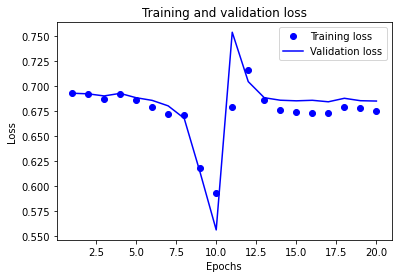

In [29]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Training and validation loss를 그려 보면, 몇 epoch까지의 트레이닝이 적절한지 최적점을 추정해 볼 수 있다. 

validation loss의 그래프가 train loss와의 이격이 발생하게 되면 더 이상의 트레이닝은 무의미해지게 된다.

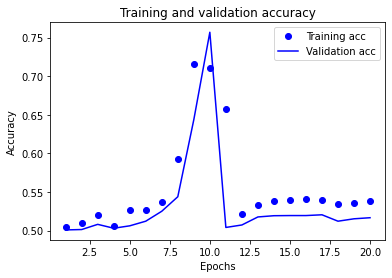

In [30]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

마찬가지로 Training and validation accuracy를 그려 보아도 유사한 인사이트를 얻을 수 있다.

## Word2Vec의 적용

라벨링 비용이 많이 드는 머신러닝 기반 감성분석의 비용을 절감하면서 정확도를 크게 향상시킬 수 있는 자연어처리 기법으로 

단어의 특성을 저차원 벡터값으로 표현할 수 있는 워드 임베딩(word embedding) 기법이 있으며 

사용했던 model의 첫 번째 레이어는 바로 Embedding 레이어였다. 

이 레이어는 우리가 가진 사전의 단어 개수 X 워드 벡터 사이즈만큼의 크기를 가진 학습 파라미터였으며 

우리의 감성분류 모델이 학습이 잘 되었다면, Embedding 레이어에 학습된 우리의 워드 벡터들도 의미 공간상에 유의미한 형태로 학습되었을 것이다 

이번 스텝부터 워드 벡터 파일을 저장할 디렉토리를 먼저 생성하고 워드 벡터를 다루는데 유용한 gensim 패키지 버전 확인을 합니다.

$ mkdir -p ~/aiffel/EXPLORATION/07/sentiment_classification/data

$ pip list | grep gensim

$ pip install -U gensim==3.8.3

In [31]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [32]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/EXPLORATION/07/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용

In [33]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector

/opt/conda/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


array([ 0.01032429,  0.02573344,  0.09129182,  0.08418722,  0.06898449,
        0.040397  ,  0.00333357,  0.00785767, -0.02376186,  0.0196318 ,
       -0.06224685,  0.02179324, -0.05684815, -0.03302259, -0.00787909,
       -0.06919963], dtype=float32)

In [34]:
word_vectors.similar_by_word("love")

[('excuses', 0.9492953419685364),
 ('mice', 0.9286916851997375),
 ('punch', 0.9248488545417786),
 ('dinner', 0.9229894876480103),
 ('captivating', 0.9211410880088806),
 ('heartwarming', 0.9208500385284424),
 ('mick', 0.9161656498908997),
 ('unpredictable', 0.9154671430587769),
 ('placed', 0.9149525165557861),
 ('motion', 0.9132136702537537)]

구글에서 제공하는 Word2Vec이라는 사전학습된(Pretrained) 워드 임베딩 모델을 가져다 활용해 보기..

Word2Vec은 무려 1억 개의 단어로 구성된 Google News dataset을 바탕으로 학습되었으며, 총 300만 개의 단어를 각각 300차원의 벡터로 표현한 것이다.

Word2Vec이라는 것도 Embedding Layer와 원리는 동일하며, 왜 사전학습된 임베딩을 활용하는 것이 유리한지 설명해 주고 있는데, 전이학습 때문입니다.

$ ln -s ~/data/GoogleNews-vectors-negative300.bin.gz ~/aiffel/EXPLORATION/07/sentiment_classification/data

In [35]:
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/EXPLORATION/07/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector     # 무려 300dim의 워드 벡터입니다.

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

300dim의 벡터로 이루어진 300만 개의 단어입니다. 

이 단어 사전을 메모리에 모두 로딩하면 아주 높은 확률로 여러분의 실습환경에 메모리 에러가 날 것입니다. 

그래서 KeyedVectors.load_word2vec_format 메소드로 워드 벡터를 로딩할 때 가장 많이 사용되는 상위 100만 개만 limt으로 조건을 주어 로딩했습니다.

메모리가 충분하다면 limt=None으로 하시면 300만 개를 모두 로딩합니다.

In [35]:
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/EXPLORATION/07/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=None)
vector = word2vec['computer']
vector     # 무려 300dim의 워드 벡터입니다.

KeyboardInterrupt: 

In [36]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("love")

[('loved', 0.6907791495323181),
 ('adore', 0.6816873550415039),
 ('loves', 0.661863386631012),
 ('passion', 0.6100708842277527),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547304749488831),
 ('absolutely_adore', 0.5536840558052063),
 ('adores', 0.5440906882286072)]

이전 스텝에서 학습했던 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여 다시 학습시켜 보면....

In [37]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [38]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 580, 300)          3000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 574, 16)           33616     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 114, 16)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 108, 16)           1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [39]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 19s 488ms/step - loss: 0.6869 - accuracy: 0.5394 - val_loss: 0.6634 - val_accuracy: 0.6196
Epoch 2/20
30/30 [==============================] - 11s 359ms/step - loss: 0.6350 - accuracy: 0.6664 - val_loss: 0.5588 - val_accuracy: 0.7152
Epoch 3/20
30/30 [==============================] - 11s 359ms/step - loss: 0.4849 - accuracy: 0.7829 - val_loss: 0.3831 - val_accuracy: 0.8381
Epoch 4/20
30/30 [==============================] - 11s 359ms/step - loss: 0.3141 - accuracy: 0.8770 - val_loss: 0.3293 - val_accuracy: 0.8567
Epoch 5/20
30/30 [==============================] - 11s 360ms/step - loss: 0.2310 - accuracy: 0.9113 - val_loss: 0.3037 - val_accuracy: 0.8741
Epoch 6/20
30/30 [==============================] - 11s 360ms/step - loss: 0.1737 - accuracy: 0.9406 - val_loss: 0.3177 - val_accuracy: 0.8658
Epoch 7/20
30/30 [==============================] - 11s 360ms/step - loss: 0.1300 - accuracy: 0.9612 - val_loss: 0.3024 - val_accuracy: 0.8784

In [40]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 9s - loss: 0.5411 - accuracy: 0.8615
[0.5410572290420532, 0.861519992351532]


## 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

한국어 텍스트의 감정분석을 진행해 보기위해 활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된 Naver sentiment movie corpus입니다.

$ ln -s ~/data/*.txt ~/aiffel/EXPLORATION/07/sentiment_classification/data

### 1) 데이터 준비와 확인

In [41]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/EXPLORATION/07/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/EXPLORATION/07/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2) 데이터로더 구성

nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 

이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. 

data_loader 안에서는 다음을 수행해야 합니다.

- 데이터의 중복 제거

- NaN 결측치 제거

- 한국어 토크나이저로 토큰화

- 불용어(Stopwords) 제거

- 사전word_to_index 구성

- 텍스트 스트링을 사전 인덱스 스트링으로 변환

- X_train, y_train, X_test, y_test, word_to_index 리턴

In [43]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [44]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [45]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 모델구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포

- 적절한 최대 문장 길이 지정

- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

데이터셋 내 문장 길이 분포

In [46]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


적절한 최대 문장 길이 지정

In [47]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [48]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)



(25000, 41)


In [49]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


### 4) 모델구성 및 validation set 구성

In [50]:
vocab_size = 10000    
word_vector_dim = 16

모델 1

In [51]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


모델 2

In [52]:
model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.Conv1D(1024, 7, activation='relu'))
model1.add(keras.layers.MaxPooling1D(5))
model1.add(keras.layers.Conv1D(512, 7, activation='relu'))
model1.add(keras.layers.GlobalMaxPooling1D())
model1.add(keras.layers.Dense(128, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid')) 

model1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 1024)        115712    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 1024)        0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 512)         3670528   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

모델 3

In [53]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  

model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


### 5) 모델 훈련 개시

In [54]:
X_val = X_train[:10000]   
y_val = y_train[:10000]

partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


모델 1

In [55]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=8 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/8
266/266 [==============================] - 4s 11ms/step - loss: 0.5935 - accuracy: 0.6896 - val_loss: 0.3577 - val_accuracy: 0.8471
Epoch 2/8
266/266 [==============================] - 2s 9ms/step - loss: 0.3389 - accuracy: 0.8577 - val_loss: 0.3398 - val_accuracy: 0.8535
Epoch 3/8
266/266 [==============================] - 3s 9ms/step - loss: 0.3105 - accuracy: 0.8726 - val_loss: 0.3410 - val_accuracy: 0.8540
Epoch 4/8
266/266 [==============================] - 2s 9ms/step - loss: 0.2951 - accuracy: 0.8785 - val_loss: 0.3471 - val_accuracy: 0.8533
Epoch 5/8
266/266 [==============================] - 3s 9ms/step - loss: 0.2824 - accuracy: 0.8860 - val_loss: 0.3470 - val_accuracy: 0.8523
Epoch 6/8
266/266 [==============================] - 3s 9ms/step - loss: 0.2685 - accuracy: 0.8934 - val_loss: 0.3509 - val_accuracy: 0.8540
Epoch 7/8
266/266 [==============================] - 3s 10ms/step - loss: 0.2589 - accuracy: 0.8976 - val_loss: 0.3573 - val_accuracy: 0.8536
Epoch 8/8
2

epoch에 따른 그래프를 그려볼 수 있는 항목들

In [56]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


모델 2

In [57]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=8  

history1 = model1.fit(partial_X_train,
                     partial_y_train,
                     epochs=epochs,
                     batch_size=512,
                     validation_data=(X_val, y_val),
                     verbose=1)

Epoch 1/8
266/266 [==============================] - 28s 93ms/step - loss: 0.5002 - accuracy: 0.7242 - val_loss: 0.3268 - val_accuracy: 0.8543
Epoch 2/8
266/266 [==============================] - 21s 80ms/step - loss: 0.2925 - accuracy: 0.8769 - val_loss: 0.3101 - val_accuracy: 0.8633
Epoch 3/8
266/266 [==============================] - 21s 80ms/step - loss: 0.2364 - accuracy: 0.9048 - val_loss: 0.3228 - val_accuracy: 0.8602
Epoch 4/8
266/266 [==============================] - 21s 80ms/step - loss: 0.1866 - accuracy: 0.9291 - val_loss: 0.3588 - val_accuracy: 0.8528
Epoch 5/8
266/266 [==============================] - 21s 80ms/step - loss: 0.1404 - accuracy: 0.9497 - val_loss: 0.4050 - val_accuracy: 0.8530
Epoch 6/8
266/266 [==============================] - 21s 80ms/step - loss: 0.1073 - accuracy: 0.9624 - val_loss: 0.4823 - val_accuracy: 0.8528
Epoch 7/8
266/266 [==============================] - 21s 81ms/step - loss: 0.0848 - accuracy: 0.9707 - val_loss: 0.5520 - val_accuracy: 0.8453

In [58]:
history1_dict = history1.history
print(history1_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


모델 3

In [59]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
               metrics=['accuracy'])
              
epochs=8 

history2 = model2.fit(partial_X_train,
                     partial_y_train,
                     epochs=epochs,
                     batch_size=512,
                     validation_data=(X_val, y_val),
                     verbose=1)

Epoch 1/8
266/266 [==============================] - 2s 5ms/step - loss: 0.6443 - accuracy: 0.6786 - val_loss: 0.4052 - val_accuracy: 0.8255
Epoch 2/8
266/266 [==============================] - 1s 4ms/step - loss: 0.3768 - accuracy: 0.8395 - val_loss: 0.3533 - val_accuracy: 0.8427
Epoch 3/8
266/266 [==============================] - 1s 4ms/step - loss: 0.3220 - accuracy: 0.8651 - val_loss: 0.3444 - val_accuracy: 0.8469
Epoch 4/8
266/266 [==============================] - 1s 4ms/step - loss: 0.2974 - accuracy: 0.8766 - val_loss: 0.3453 - val_accuracy: 0.8499
Epoch 5/8
266/266 [==============================] - 1s 4ms/step - loss: 0.2737 - accuracy: 0.8888 - val_loss: 0.3496 - val_accuracy: 0.8506
Epoch 6/8
266/266 [==============================] - 1s 4ms/step - loss: 0.2569 - accuracy: 0.8956 - val_loss: 0.3553 - val_accuracy: 0.8485
Epoch 7/8
266/266 [==============================] - 1s 4ms/step - loss: 0.2454 - accuracy: 0.9011 - val_loss: 0.3637 - val_accuracy: 0.8481
Epoch 8/8
266

In [60]:
history2_dict = history2.history
print(history2_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### 6) Loss, Accuracy 그래프 시각화

모델 1

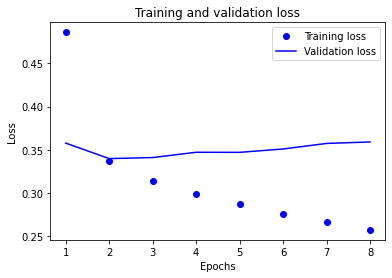

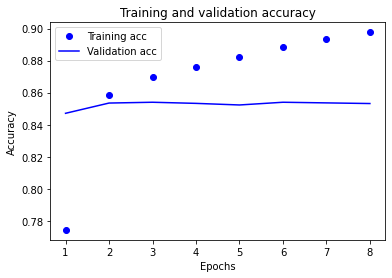

In [61]:
import matplotlib.pyplot as plt
plt.clf()


# loss

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# accuracy

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Epoch = 4일때 Training Loss와 Validation Loss가 둘 다 감소함을 확인 => 7에서 정확도 다시 확인

모델 2

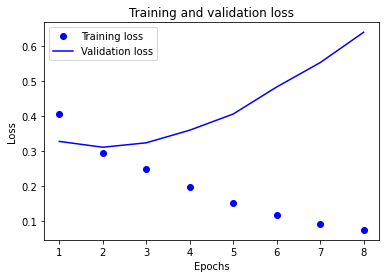

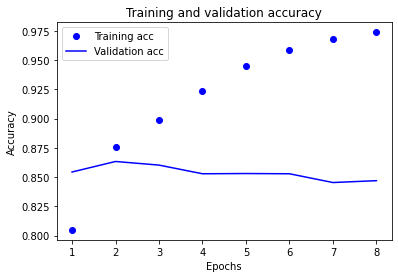

In [62]:
import matplotlib.pyplot as plt
plt.clf()


# loss

acc1 = history1_dict['accuracy']
val_acc1 = history1_dict['val_accuracy']
loss1 = history1_dict['loss']
val_loss1 = history1_dict['val_loss']

epochs1 = range(1, len(acc1) + 1)

plt.plot(epochs1, loss1, 'bo', label='Training loss')
plt.plot(epochs1, val_loss1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# accuracy

plt.plot(epochs1, acc1, 'bo', label='Training acc')
plt.plot(epochs1, val_acc1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Epoch = 2일때 Training Loss와 Validation Loss가 둘 다 감소함을 확인 => 7에서 정확도 다시 확인

모델 3

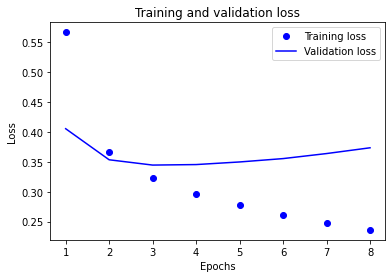

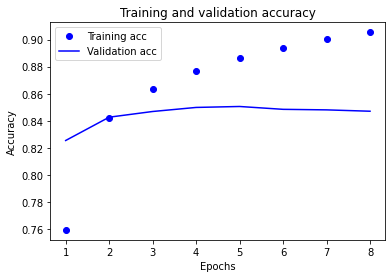

In [63]:
import matplotlib.pyplot as plt
plt.clf()

# loss

acc2 = history2_dict['accuracy']
val_acc2 = history2_dict['val_accuracy']
loss2 = history2_dict['loss']
val_loss2 = history2_dict['val_loss']

epochs2 = range(1, len(acc2) + 1)

plt.plot(epochs2, loss2, 'bo', label='Training loss')
plt.plot(epochs2, val_loss2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# accuracy

plt.plot(epochs2, acc2, 'bo', label='Training acc')
plt.plot(epochs2, val_acc2, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Epoch = 3일때 Training Loss와 Validation Loss가 둘 다 감소함을 확인 => 7에서 정확도 다시 확인

### 7) 학습된 Embedding 레이어 분석

모델 1

In [64]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 16)


In [65]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


epoch = 4 일때

In [66]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=4 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/4
266/266 [==============================] - 4s 11ms/step - loss: 0.5908 - accuracy: 0.6824 - val_loss: 0.3577 - val_accuracy: 0.8458
Epoch 2/4
266/266 [==============================] - 3s 10ms/step - loss: 0.3421 - accuracy: 0.8556 - val_loss: 0.3424 - val_accuracy: 0.8528
Epoch 3/4
266/266 [==============================] - 3s 9ms/step - loss: 0.3196 - accuracy: 0.8678 - val_loss: 0.3431 - val_accuracy: 0.8523
Epoch 4/4
266/266 [==============================] - 3s 9ms/step - loss: 0.3060 - accuracy: 0.8738 - val_loss: 0.3440 - val_accuracy: 0.8530


모델 1 결과

In [67]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.3565 - accuracy: 0.8460
[0.356504887342453, 0.8459629416465759]


모델 2

In [68]:
embedding_layer1 = model1.layers[0]
weights1 = embedding_layer1.get_weights()[0]
print(weights1.shape)


(10000, 16)


In [69]:
model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.Conv1D(1024, 7, activation='relu'))
model1.add(keras.layers.MaxPooling1D(5))
model1.add(keras.layers.Conv1D(512, 7, activation='relu'))
model1.add(keras.layers.GlobalMaxPooling1D())
model1.add(keras.layers.Dense(128, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid')) 

model1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 1024)        115712    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 1024)        0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 512)         3670528   
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                

epoch = 2 일때

In [70]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=2  

history1 = model1.fit(partial_X_train,
                     partial_y_train,
                     epochs=epochs,
                     batch_size=512,
                     validation_data=(X_val, y_val),
                     verbose=1)

Epoch 1/2
266/266 [==============================] - 22s 80ms/step - loss: 0.5022 - accuracy: 0.7240 - val_loss: 0.3323 - val_accuracy: 0.8535
Epoch 2/2
266/266 [==============================] - 21s 79ms/step - loss: 0.2995 - accuracy: 0.8748 - val_loss: 0.3225 - val_accuracy: 0.8573


모델 2 결과

In [71]:
results1 = model1.evaluate(X_test,  y_test, verbose=2)

print(results1)

1537/1537 - 8s - loss: 0.3359 - accuracy: 0.8551
[0.3359029293060303, 0.8551376461982727]


모델 3

In [72]:
embedding_layer2 = model2.layers[0]
weights2 = embedding_layer2.get_weights()[0]
print(weights2.shape)

(10000, 16)


In [73]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  

model2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 16)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


epoch = 3 일때

In [74]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
               metrics=['accuracy'])
              
epochs=3 

history2 = model2.fit(partial_X_train,
                     partial_y_train,
                     epochs=epochs,
                     batch_size=512,
                     validation_data=(X_val, y_val),
                     verbose=1)

Epoch 1/3
266/266 [==============================] - 2s 5ms/step - loss: 0.6375 - accuracy: 0.6878 - val_loss: 0.3977 - val_accuracy: 0.8285
Epoch 2/3
266/266 [==============================] - 1s 4ms/step - loss: 0.3755 - accuracy: 0.8397 - val_loss: 0.3489 - val_accuracy: 0.8451
Epoch 3/3
266/266 [==============================] - 1s 4ms/step - loss: 0.3170 - accuracy: 0.8668 - val_loss: 0.3411 - val_accuracy: 0.8502


모델 3 결과

In [75]:
results2 = model2.evaluate(X_test,  y_test, verbose=2)

print(results2)

1537/1537 - 2s - loss: 0.3559 - accuracy: 0.8440
[0.3559008836746216, 0.8439693450927734]


### gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩 비교

자체학습 word_vector를 파일에 기록하기

In [76]:
import os
 
word2vec_file_path = os.getenv('HOME')+'/aiffel/EXPLORATION/07/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) 

vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

자체학습 '사랑'이란 단어 word_vector 확인

In [77]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

array([-0.05908241,  0.1179832 , -0.07417253,  0.07143138,  0.11014896,
       -0.14524256,  0.06384004,  0.11958434, -0.1169332 , -0.11808105,
       -0.03588134,  0.06602988,  0.04899168,  0.09418859, -0.10722475,
        0.08927731], dtype=float32)

자체학습 '재미'라는 단어 유사도 찾기

In [78]:
word_vectors.similar_by_word("재미")

[('난리', 0.8853654861450195),
 ('느', 0.765455424785614),
 ('센스', 0.7554619908332825),
 ('빈다', 0.7480915188789368),
 ('교훈', 0.7434333562850952),
 ('먼가', 0.727645754814148),
 ('초', 0.7249915599822998),
 ('고등학교', 0.7197641730308533),
 ('줘야', 0.7175693511962891),
 ('도망치', 0.7088519930839539)]

사전학습 '사랑'라는 word_vector 확인

In [83]:
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/EXPLORATION/07/sentiment_classification/data/ko.vec'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=False, limit=1000000)
vector = word2vec['사랑']
vector

array([ 7.2242e-02, -6.9223e-02,  2.6350e-01,  2.6930e-02,  2.7465e-01,
       -5.7484e-02,  1.1657e-01, -1.0736e-01,  2.6542e-01, -1.5600e-01,
        4.8601e-01,  6.3728e-01,  5.7949e-01,  2.1420e-01, -3.2206e-02,
       -9.1503e-03,  2.0928e-01, -8.1857e-02, -2.6783e-01, -2.5602e-01,
        1.4733e-01,  4.5259e-01,  3.6965e-01,  2.4644e-01, -4.4918e-02,
       -6.7232e-02,  3.1724e-02,  3.3469e-01,  2.6623e-01, -1.1605e-01,
       -1.5161e-02,  1.0318e-01,  1.4193e-01, -7.9796e-02,  1.5111e-02,
        1.0474e-01, -2.3739e-01, -1.1473e-01, -5.4767e-02,  8.9843e-02,
        3.1133e-01,  3.2850e-01,  9.2288e-02, -1.3007e-01, -4.7345e-01,
       -4.1861e-01, -2.1817e-01, -1.6687e-02,  3.4634e-01,  1.1898e-01,
        2.5232e-01,  5.3454e-03,  9.8491e-02,  1.4123e-01,  2.8660e-02,
       -1.1567e-01,  5.5575e-01, -1.4759e-01,  2.7344e-01, -2.9719e-01,
        7.8230e-02, -2.1698e-01, -1.9905e-01,  3.0314e-01, -4.5031e-02,
        1.6996e-01, -3.5892e-01, -2.6847e-01,  1.4510e-01, -2.09

사전학습 '재미'라는 단어 유사도 찾기

In [84]:
word2vec.similar_by_word("재미")

[('재미있', 0.54170823097229),
 ('흥미', 0.502285897731781),
 ('한국인', 0.5001273155212402),
 ('교포', 0.48998966813087463),
 ('재밌', 0.45642775297164917),
 ('팬클럽', 0.44300568103790283),
 ('동포', 0.4352205991744995),
 ('공감', 0.43383821845054626),
 ('인기도', 0.43197956681251526),
 ('유머', 0.43098777532577515)]

### 8) 한국어 Word2Vec 임베딩 활용하여 성능개선

어휘사전 구축

In [85]:
vocab_size = 10000    
word_vector_dim = 200  

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

모델 구성 후 카피한 임베딩 활용

In [86]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    
word_vector_dim = 200  


model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  
                                 input_length=maxlen, 
                                 trainable=True))  
model.add(keras.layers.Conv1D(1024, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(512, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 35, 1024)          1434624   
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 7, 1024)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1, 512)            3670528   
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_23 (Dense)             (None, 1)               

학습의 진행

In [87]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
             metrics=['accuracy'])
              
epochs=8  

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/8
266/266 [==============================] - 43s 153ms/step - loss: 0.6369 - accuracy: 0.6658 - val_loss: 0.3522 - val_accuracy: 0.8501
Epoch 2/8
266/266 [==============================] - 39s 148ms/step - loss: 0.3299 - accuracy: 0.8576 - val_loss: 0.3348 - val_accuracy: 0.8560
Epoch 3/8
266/266 [==============================] - 40s 149ms/step - loss: 0.2823 - accuracy: 0.8840 - val_loss: 0.3252 - val_accuracy: 0.8614
Epoch 4/8
266/266 [==============================] - 40s 149ms/step - loss: 0.2307 - accuracy: 0.9084 - val_loss: 0.3453 - val_accuracy: 0.8632
Epoch 5/8
266/266 [==============================] - 40s 149ms/step - loss: 0.1725 - accuracy: 0.9354 - val_loss: 0.3888 - val_accuracy: 0.8517
Epoch 6/8
266/266 [==============================] - 40s 149ms/step - loss: 0.1358 - accuracy: 0.9488 - val_loss: 0.4594 - val_accuracy: 0.8558
Epoch 7/8
266/266 [==============================] - 40s 149ms/step - loss: 0.1033 - accuracy: 0.9615 - val_loss: 0.5593 - val_accuracy:

epoch에 따른 그래프를 그려볼 수 있는 항목들

In [88]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


 loss와 accuracy 그래프화

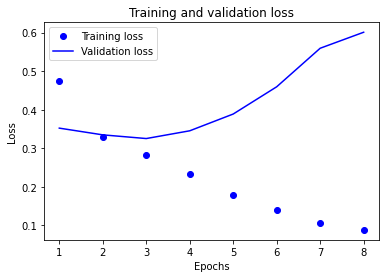

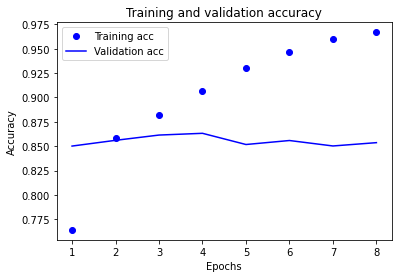

In [89]:
import matplotlib.pyplot as plt
plt.clf()


# loss

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# accuracy

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

학습된 Embedding 레이어 분석

In [90]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 200)


In [91]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    
word_vector_dim = 200  


model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  
                                 input_length=maxlen, 
                                 trainable=True))  
model.add(keras.layers.Conv1D(1024, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(512, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 35, 1024)          1434624   
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 7, 1024)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 1, 512)            3670528   
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_25 (Dense)             (None, 1)               

epoch = 3일때

In [92]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
             metrics=['accuracy'])
              
epochs=3  

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/3
266/266 [==============================] - 40s 149ms/step - loss: 0.6603 - accuracy: 0.6624 - val_loss: 0.3534 - val_accuracy: 0.8470
Epoch 2/3
266/266 [==============================] - 39s 148ms/step - loss: 0.3303 - accuracy: 0.8578 - val_loss: 0.3269 - val_accuracy: 0.8541
Epoch 3/3
266/266 [==============================] - 39s 148ms/step - loss: 0.2796 - accuracy: 0.8842 - val_loss: 0.3264 - val_accuracy: 0.8582


한국어 word2vec 모델 최종결과

In [93]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 10s - loss: 0.3458 - accuracy: 0.8517
[0.3457895517349243, 0.8516793251037598]
